<a href="https://colab.research.google.com/github/8Chatea8/HeadChecker/blob/main/model/20230904_Mahi_Mahi_data_whole_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 2023.09.04.
담당: 노유현  
데이터: train: data_whole.csv  
모델: 'bert-base-multilingual-cased'  
파라미터: MAX_LEN = 450/batch_size = 8/epoch=4  

In [ ]:
# Hugging Face의 트랜스포머 모델 및 라이브러리 설치
!pip install transformers
!pip install tensorflow
!pip install torch
!pip install -U scikit-learn
!pip install pandas numpy

  Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
filelock 3.12.3 requires typing-extensions>=4.7.1; python_version < "3.11", but you have typing-extensions 4.5.0 which is incompatible.
  Obtaining dependency information for typing-extensions from https://files.pythonhosted.org/packages/ec/6b/63cc3df74987c36fe26157ee12e09e8f9db4de771e0f3404263117e75b95/typing_extensions-4.7.1-py3-none-any.whl.metadata
  Using cached typing_extensions-4.7.1-py3-none-any.whl.metadata (3.1 kB)
Using cached typing_extensions-4.7.1-py3-none-any.whl (33 kB)
  Attempting uninstall: typing-extensions
    Found existing installation:

In [ ]:
import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime

2023-09-04 14:35:00.294877: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-04 14:35:00.401415: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-04 14:35:00.882383: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
# 메모리 삭제 : CUDA out of memery

torch.cuda.empty_cache()

In [ ]:
#### "CUDA 메모리 부족"

# 1.배치 크기 줄이기:  batch_size 매개변수를 수정
# 2.메모리 해제:  torch.cuda.empty_cache()
# 3.시퀀스 길이 제한: 입력 시퀀스를 자르거나 작은 부분으로 나눈다. BERT와 같은 모델은 메모리 사용량에 시퀀스 길이의 제곱 종속성이 있음
# 4.기울기 클리핑 사용: 최적화 단계에서 기울기 클리핑을 적용
# 5.모델 크기 감소: 위의 솔루션 중 어느 것도 도움이 되지 않는 경우, 더 작은 모델 버전을 사용하거나 메모리 사용량이 더 적은 다른 모델 아키텍처를 고려

### 데이터 로드

In [ ]:
# 데이터 로드
df = pd.read_csv('/home/hyunkoo/DATA/Uhyeon/data_whole.csv', encoding='utf-8')

df.head()

,Headline,Content,Class
0,광주지역 소상공인의 외침... 코로나 직격탄 맞은 소상공인 도울 방법은?,신종 코로나바이러스 감염증 직격탄을 맞은 소상공인들이 저마다 절박한 심정으로 지원을...,0
1,"“과일 껍질 세척 후 드세요”…경기보건환경硏, 과일 껍질 잔류농약 검출률 과육의 10배",경기도보건환경연구원은 지난해 1월부터 8월까지 온라인 및 도내 대형마트에서 유통된 ...,1
2,늙은 부모님 악몽 꾼다면…이 병 걸릴 확률 높다,노년에 악몽을 자주 꾸는 것은 파킨슨병을 예고하는 경고 신호일 수 있다는 연구 결과...,1
3,13세 친딸 몸쓸짓하고 “친구 소개해줘… 40대父 징역 12년,13세 친딸을 수차례 성폭행하고 학대한 혐의로 재판에 넘겨진 40대 남성에게 법원이...,1
4,"경과원, 인공지능?가상현실 기술 성과공유회 개최",경기도경제과학진흥원은 16일부터 이틀간 경기창조경제혁신센터 국제회의장에서‘2021 ...,1


In [ ]:
print(df.shape)

(318132, 3)


In [ ]:
df['Class'].value_counts() # 진짜뉴스 1: 41,332개 / 낚시뉴스 0: 29,663개

Class
1    162468
0    155664
Name: count, dtype: int64

In [ ]:
# Class가 0인 데이터의 인덱스 출력 (첫 5개)
class_0_indices = df[df['Class'] == 0].index[:5]

# Class가 1인 데이터의 인덱스 출력 (첫 5개)
class_1_indices = df[df['Class'] == 1].index[:5]

# 결과 출력
print("Class 0 데이터의 인덱스 (첫 5개):", class_0_indices)
print("Class 1 데이터의 인덱스 (첫 5개):", class_1_indices)

Class 0 데이터의 인덱스 (첫 5개): Index([0, 6, 12, 17, 20], dtype='int64')
Class 1 데이터의 인덱스 (첫 5개): Index([1, 2, 3, 4, 5], dtype='int64')


### 데이터 전처리

1. 특수토큰 삽입 [CLS] + 헤드라인 + [SEP] + 본문 + [SEP]
2. 토크나이징(BertTokenizer.from_pretrained('bert-base-multilingual-cased' 사용))
3. MAX_LEN에 맞게 패딩
4. 패딩에 맞게 어텐션 마스크 만듦
5. train, validation으로 나눔(9:1)
6. Dataloader에 피딩

In [ ]:
## 헤드라인 데이터 전처리

sentences_h = df['Headline']
sentences_h.head()

0            광주지역 소상공인의 외침... 코로나 직격탄 맞은 소상공인 도울 방법은?
1    “과일 껍질 세척 후 드세요”…경기보건환경硏, 과일 껍질 잔류농약 검출률 과육의 10배
2                          늙은 부모님 악몽 꾼다면…이 병 걸릴 확률 높다
3                  13세 친딸 몸쓸짓하고 “친구 소개해줘… 40대父 징역 12년
4                          경과원, 인공지능?가상현실 기술 성과공유회 개최
Name: Headline, dtype: object

In [ ]:
## 헤드라인 BERT의 입력 형식에 맞게 변환
sentences_h = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences_h]
sentences_h[:5]

['[CLS] 광주지역 소상공인의 외침... 코로나 직격탄 맞은 소상공인 도울 방법은? [SEP]',
 '[CLS] “과일 껍질 세척 후 드세요”…경기보건환경硏, 과일 껍질 잔류농약 검출률 과육의 10배 [SEP]',
 '[CLS] 늙은 부모님 악몽 꾼다면…이 병 걸릴 확률 높다 [SEP]',
 '[CLS] 13세 친딸 몸쓸짓하고 “친구 소개해줘… 40대父 징역 12년 [SEP]',
 '[CLS] 경과원, 인공지능?가상현실 기술 성과공유회 개최 [SEP]']

In [ ]:
# 본문 데이터 전처리

sentences_c = df['Content']
sentences_c[:5]

0    신종 코로나바이러스 감염증 직격탄을 맞은 소상공인들이 저마다 절박한 심정으로 지원을...
1    경기도보건환경연구원은 지난해 1월부터 8월까지 온라인 및 도내 대형마트에서 유통된 ...
2    노년에 악몽을 자주 꾸는 것은 파킨슨병을 예고하는 경고 신호일 수 있다는 연구 결과...
3    13세 친딸을 수차례 성폭행하고 학대한 혐의로 재판에 넘겨진 40대 남성에게 법원이...
4    경기도경제과학진흥원은 16일부터 이틀간 경기창조경제혁신센터 국제회의장에서‘2021 ...
Name: Content, dtype: object

In [ ]:
# BERT의 입력 형식에 맞게 변환
sentences_c = [ str(sentence) + " [SEP]" for sentence in sentences_c]
sentences_c[:5]

['신종 코로나바이러스 감염증 직격탄을 맞은 소상공인들이 저마다 절박한 심정으로 지원을 호소했다.\n광주시는 10일 시청 중회의실에서 지역 소상공업종 대표들과 간담회를 하고 건의 사항을 청취했다.\n이날 간담회에는 상인연합회를 비롯해 학원, 노래연습장, 예식업, 단란주점, 제과점, 휴게음식점, 목욕탕, 숙박, 세탁, 이미용업 등 업종 대표 14명이 참석했다.\n소상공인들은 매출 감소와 각종 제한에 따른 어려움을 토로하고 지원을 요청했다.\n예식업 대표는 매출 규모를 기준으로 하다 보니 재난 지원금과 시 지원 대상에서 제외됐다고 고충을 털어놨다.\n목욕업 대표는 손님이 없어도 물을 데워야 하는 특성상 공공요금 부담이 크다 면서 기본요금 감면 등 실질적인 지원이 필요하다고 호소했다.\n70세 이상 기초생활보장 수급자, 차상위 계층 노인을 위한 경로 목욕비 바우처 사업도 제안됐다.\n세탁업 대표는 사업자 등록을 하지 않은 업소들은 영업 신고증이 있어도 정부 지원에서 누락되는 경우가 많다며 지원을 호소했다.\n숙박업 대표는 연 매출 4억원 이상 사업자를 지원에서 제외하는 문제점을 지적하고 착한 임대료 운동을 확산시켜달라고 건의했다.\n이용섭 광주시장은 미디어SR에 코로나19라는 사회 재난으로 큰 어려움을 겪는 소상공인들의 심정을 충분히 이해한다 며 소상공인이 행복해야 광주가 행복하다는 마음으로 간담회에서 나온 의견을 정책에 반영해 지원 대책을 강구하겠다고 밝혔다. [SEP]',
 '경기도보건환경연구원은 지난해 1월부터 8월까지 온라인 및 도내 대형마트에서 유통된 과일류 등 20품목 114건에 대한 잔류 농약 함량을 조사한 결과 껍질의 잔류농약 검출률이 과육의 10배 이상인 것으로 나타났다고 3일 밝혔다.\n이에 따라 연구원은 껍질에서 검출된 농약 성분이 대부분 기준치 이내이지만 껍질을 세척 후 섭취할 것을 권장했다.\n식품 안전을 위한 과일 잔류 농약 검사는 꼭지만 제거 후 껍질과 과육을 함께 갈아서 진행하는데, 이번 연구원의 검사는 기존 방식과 과피·과육 분리 방식

In [ ]:
# 각 헤드라인과 본문을 하나로 붙여서 sentences 만들기

sentences = []

for i in range(len(sentences_h)):
    sentence = sentences_h[i] + " " + sentences_c[i]
    sentences.append(sentence)

# 결과 출력
for sentence in sentences[:5]:
    print(sentence)

[CLS] 광주지역 소상공인의 외침... 코로나 직격탄 맞은 소상공인 도울 방법은? [SEP] 신종 코로나바이러스 감염증 직격탄을 맞은 소상공인들이 저마다 절박한 심정으로 지원을 호소했다.
광주시는 10일 시청 중회의실에서 지역 소상공업종 대표들과 간담회를 하고 건의 사항을 청취했다.
이날 간담회에는 상인연합회를 비롯해 학원, 노래연습장, 예식업, 단란주점, 제과점, 휴게음식점, 목욕탕, 숙박, 세탁, 이미용업 등 업종 대표 14명이 참석했다.
소상공인들은 매출 감소와 각종 제한에 따른 어려움을 토로하고 지원을 요청했다.
예식업 대표는 매출 규모를 기준으로 하다 보니 재난 지원금과 시 지원 대상에서 제외됐다고 고충을 털어놨다.
목욕업 대표는 손님이 없어도 물을 데워야 하는 특성상 공공요금 부담이 크다 면서 기본요금 감면 등 실질적인 지원이 필요하다고 호소했다.
70세 이상 기초생활보장 수급자, 차상위 계층 노인을 위한 경로 목욕비 바우처 사업도 제안됐다.
세탁업 대표는 사업자 등록을 하지 않은 업소들은 영업 신고증이 있어도 정부 지원에서 누락되는 경우가 많다며 지원을 호소했다.
숙박업 대표는 연 매출 4억원 이상 사업자를 지원에서 제외하는 문제점을 지적하고 착한 임대료 운동을 확산시켜달라고 건의했다.
이용섭 광주시장은 미디어SR에 코로나19라는 사회 재난으로 큰 어려움을 겪는 소상공인들의 심정을 충분히 이해한다 며 소상공인이 행복해야 광주가 행복하다는 마음으로 간담회에서 나온 의견을 정책에 반영해 지원 대책을 강구하겠다고 밝혔다. [SEP]
[CLS] “과일 껍질 세척 후 드세요”…경기보건환경硏, 과일 껍질 잔류농약 검출률 과육의 10배 [SEP] 경기도보건환경연구원은 지난해 1월부터 8월까지 온라인 및 도내 대형마트에서 유통된 과일류 등 20품목 114건에 대한 잔류 농약 함량을 조사한 결과 껍질의 잔류농약 검출률이 과육의 10배 이상인 것으로 나타났다고 3일 밝혔다.
이에 따라 연구원은 껍질에서 검출된 농약 성분이 대부분 기준치 이내이지만 껍질을 세척 후 

In [ ]:
# Class(라벨) 추출 : 가짜뉴스 0 / 진짜뉴스 1
labels = df['Class'].values
labels

array([0, 1, 1, ..., 0, 1, 0])

In [ ]:
# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print (sentences[0])
print (tokenized_texts[0])

[CLS] 광주지역 소상공인의 외침... 코로나 직격탄 맞은 소상공인 도울 방법은? [SEP] 신종 코로나바이러스 감염증 직격탄을 맞은 소상공인들이 저마다 절박한 심정으로 지원을 호소했다.
광주시는 10일 시청 중회의실에서 지역 소상공업종 대표들과 간담회를 하고 건의 사항을 청취했다.
이날 간담회에는 상인연합회를 비롯해 학원, 노래연습장, 예식업, 단란주점, 제과점, 휴게음식점, 목욕탕, 숙박, 세탁, 이미용업 등 업종 대표 14명이 참석했다.
소상공인들은 매출 감소와 각종 제한에 따른 어려움을 토로하고 지원을 요청했다.
예식업 대표는 매출 규모를 기준으로 하다 보니 재난 지원금과 시 지원 대상에서 제외됐다고 고충을 털어놨다.
목욕업 대표는 손님이 없어도 물을 데워야 하는 특성상 공공요금 부담이 크다 면서 기본요금 감면 등 실질적인 지원이 필요하다고 호소했다.
70세 이상 기초생활보장 수급자, 차상위 계층 노인을 위한 경로 목욕비 바우처 사업도 제안됐다.
세탁업 대표는 사업자 등록을 하지 않은 업소들은 영업 신고증이 있어도 정부 지원에서 누락되는 경우가 많다며 지원을 호소했다.
숙박업 대표는 연 매출 4억원 이상 사업자를 지원에서 제외하는 문제점을 지적하고 착한 임대료 운동을 확산시켜달라고 건의했다.
이용섭 광주시장은 미디어SR에 코로나19라는 사회 재난으로 큰 어려움을 겪는 소상공인들의 심정을 충분히 이해한다 며 소상공인이 행복해야 광주가 행복하다는 마음으로 간담회에서 나온 의견을 정책에 반영해 지원 대책을 강구하겠다고 밝혔다. [SEP]
['[CLS]', '광', '##주', '##지', '##역', '소', '##상', '##공', '##인의', '외', '##침', '.', '.', '.', '코', '##로', '##나', '직', '##격', '##탄', '맞', '##은', '소', '##상', '##공', '##인', '도', '##울', '방', '##법', '##은', '?', '[SEP]', '신', '##종', '코', '##로', '##

In [ ]:
!pip install matplotlib

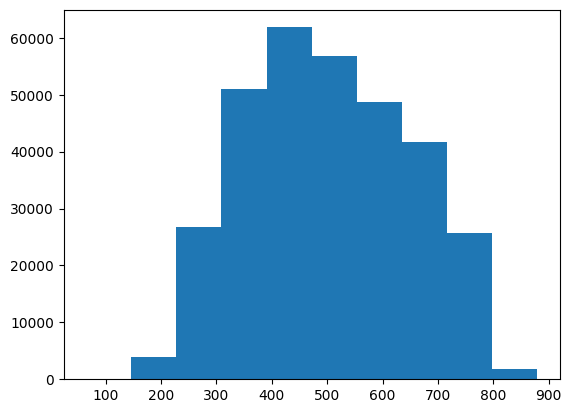

In [ ]:
import matplotlib.pyplot as plt

token_len = [len(tokenized_texts[i]) for i in range(len(tokenized_texts))]
plt.hist(token_len)
plt.show()

In [ ]:
# 입력 토큰의 최대 시퀀스 길이
MAX_LEN = 450

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids[0]

array([   101,   8903,  16323,  12508,  23160,   9448,  14871,  28000,
        48418,   9597, 119285,    119,    119,    119,   9812,  11261,
        16439,   9707,  45465,  66554,   9256,  10892,   9448,  14871,
        28000,  12030,   9087,  78123,   9328,  33768,  10892,    136,
          102,   9487,  22200,   9812,  11261,  16439,  42144,  10739,
        30873,  12605,   8848, 119144, 119230,   9707,  45465,  66554,
        10622,   9256,  10892,   9448,  14871,  28000,  12030,  20173,
         9663, 101814,   9666, 118963,  11102,   9491,  16605,  11467,
         9706,  51684,   9985,  22333,  12490,    119,   8903,  87281,
        11018,  39335,   9485,  40311,   9694,  56356,  31503,  11489,
        58939,   9448,  14871,  28000,  26784,  22200,   9069,  37824,
        72482,   8845, 105462,  88168,  32487,   8865,  10459,   9405,
        50632,  10622,   9751, 119279,  12490,    119,   9638,  41919,
         8845, 105462,  14863,  15303,   9414,  12030,  25486,  33188,
      

In [ ]:
## 어텐션 마스크

# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

In [ ]:
# 훈련셋과 검증셋으로 분리
df_inputs, validation_inputs, df_labels, validation_labels = train_test_split(input_ids,
                                                                                    labels,
                                                                                    random_state=2018,
                                                                                    test_size=0.1)

# 어텐션 마스크를 훈련셋과 검증셋으로 분리
df_masks, validation_masks, _, _ = train_test_split(attention_masks,
                                                       input_ids,
                                                       random_state=2018,
                                                       test_size=0.1)

# 데이터를 파이토치의 텐서로 변환
df_inputs = torch.tensor(df_inputs)
df_labels = torch.tensor(df_labels)
df_masks = torch.tensor(df_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

print(df_inputs[0])
print(df_labels[0])
print(df_masks[0])
print(validation_inputs[0])
print(validation_labels[0])
print(validation_masks[0])

tensor([   101,   9672, 118925,  37601,   9379,  37568,  29935,   9708,  38688,
         29455,    117,   9379,  25242,  22440,   9471,  14153,   9659,  16605,
         29455,    102,   9637,  38688,  12310,  20595, 101814,   9672, 118925,
         37601, 103064,   9379,  37568,  29935,  18623,  38688,  29455,   9670,
         30005,  11287,   9659,  16605,  29455,  22096,    119,   9356,  71439,
         70915,  12508,  58904,   9637,  38688,  12310,  20595,  10459,   9379,
         37568,  29935,   9379,  24974,   8888,  12508,   9328,  94199,   8908,
         29683,  17022,   9672,  14040,  48533,  11467,  73131,   8909,  36553,
         20173,   9637,  38688,  12310,  20595,   9638,  24974,  14040,   9379,
         37568,  29935,   9379,  72444, 106154,   9524,  12310,   9471,  11664,
           117,   9737,  12310,   9471,  71689,   9379,  37568,  29935,   9708,
         38688,  29455,  24974,   8888,  12508,   9706, 119285,  10622,   8857,
         59456,  85634,  99896,    119, 

In [ ]:
# 배치 사이즈
batch_size = 8

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
df_data = TensorDataset(df_inputs, df_masks, df_labels)
df_sampler = RandomSampler(df_data)
df_dataloader = DataLoader(df_data, sampler=df_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

### 모델 생성

In [ ]:
## 모델 생성

# GPU 디바이스 이름 구함
device_name = tf.test.gpu_device_name()

# GPU 디바이스 이름 검사
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


2023-09-04 14:41:15.936372: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-04 14:41:15.938972: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-04 14:41:15.939076: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [ ]:
# 디바이스 설정
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 4090


In [ ]:
# 분류를 위한 BERT 모델 생성
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 4

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(df_dataloader) * epochs

# 처음에 학습률을 조금씩 변화시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

/home/hyunkoo/anaconda3/envs/uhyeon/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
## 모델학습

# 정확도 계산 함수
def flat_accuracy(preds, labels):

    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))

    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

### 모델 학습

In [ ]:
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(df_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(df_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)

        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_df_loss = total_loss / len(df_dataloader)

    print("")
    print("  Average Data loss: {0:.2f}".format(avg_df_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)

        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # 그래디언트 계산 안함
        with torch.no_grad():
            # Forward 수행
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        # 출력 로짓 구함
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch   500  of  35,790.    Elapsed: 0:00:50.
  Batch 1,000  of  35,790.    Elapsed: 0:01:41.
  Batch 1,500  of  35,790.    Elapsed: 0:02:32.
  Batch 2,000  of  35,790.    Elapsed: 0:03:22.
  Batch 2,500  of  35,790.    Elapsed: 0:04:12.
  Batch 3,000  of  35,790.    Elapsed: 0:05:02.
  Batch 3,500  of  35,790.    Elapsed: 0:05:52.
  Batch 4,000  of  35,790.    Elapsed: 0:06:42.
  Batch 4,500  of  35,790.    Elapsed: 0:07:31.
  Batch 5,000  of  35,790.    Elapsed: 0:08:21.
  Batch 5,500  of  35,790.    Elapsed: 0:09:11.
  Batch 6,000  of  35,790.    Elapsed: 0:10:01.
  Batch 6,500  of  35,790.    Elapsed: 0:10:51.
  Batch 7,000  of  35,790.    Elapsed: 0:11:41.
  Batch 7,500  of  35,790.    Elapsed: 0:12:30.
  Batch 8,000  of  35,790.    Elapsed: 0:13:20.
  Batch 8,500  of  35,790.    Elapsed: 0:14:10.
  Batch 9,000  of  35,790.    Elapsed: 0:15:00.
  Batch 9,500  of  35,790.    Elapsed: 0:15:50.
  Batch 10,000  of  35,790.    Elapsed: 0:16:

In [ ]:
##### 예를 들어,
##### from transformers import BertForMaskedLM, TFAutoModelWithLMHead

##### torch_model = BertForMaskedLM.from_pretrained('bert-base-uncased')
##### tf_model = TFAutoModelWithLMHead.from_pretrained("t5-small")

# 모델 저장 방법 : save_pretrained(디렉토리)
# 모델을 저장하는 방법은 save_pretrained 함수 내에 원하는 디렉토리를 input으로 적어주시면 저장이 완료
# 파이토치 기반 모델은 pt 확장자를, 텐서플로우 기반 모델은 h5 확장자로 지정
# 모델 저장 변수 이름.save_pretrained(원하는 디렉토리) 형태

# torch_model.save_pretrained('model.pt') # 파이토치 기반 모델
# tf_model.save_pretrained('model.h5') # 텐서플로우 기반 모델

# 모델 불러오기 방법 : from_pretrained(디렉토리)
# 모델 클래스 이름.from_pretrained() 메소드로 가져오면 됩니다. 이 때, input으로 모델이 저장된 파일의 디렉토리를 적어주셔야 합니다.
# 모델 클래스 이름.from_pretrained(저장된 디렉토리) 형태

# tf_model = BertForMaskedLM.from_pretrained('/home/hyunkoo/DATA/Uhyeon/data_whole_model.pt')
# tf_model = TFAutoModelWithLMHead.from_pretrained('/home/hyunkoo/DATA/Uhyeon/data_whole_model.h5')

In [ ]:
# 모델 저장 방법 : save_pretrained(디렉토리)
# 모델 저장 변수 이름.save_pretrained(원하는 디렉토리) 형태

model_test.save_pretrained('/home/hyunkoo/DATA/Uhyeon/data_whole_model_test.pt') # 파이토치 기반 모델

In [ ]:
# 모델 불러오기 방법 : from_pretrained(디렉토리)
# 모델 클래스 이름.from_pretrained(저장된 디렉토리) 형태
model_test = BertForSequenceClassification.from_pretrained('/home/hyunkoo/DATA/Uhyeon/data_whole_model_test.pt')

In [ ]:
print(model_test)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

### 테스트셋 평가

In [ ]:
##### 테스트셋 - 전처리 #####

##### 테스트셋 - 평가 #####

# # 시작 시간 설정
# t0 = time.time()

# # 평가모드로 변경
# model.eval()

# # 변수 초기화
# eval_loss, eval_accuracy = 0, 0
# nb_eval_steps, nb_eval_examples = 0, 0

# # 데이터로더에서 배치만큼 반복하여 가져옴
# for step, batch in enumerate(test_dataloader):
#     # 경과 정보 표시
#     if step % 100 == 0 and not step == 0:
#         elapsed = format_time(time.time() - t0)
#         print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

#     # 배치를 GPU에 넣음
#     batch = tuple(t.to(device) for t in batch)

#     # 배치에서 데이터 추출
#     b_input_ids, b_input_mask, b_labels = batch

#     # 그래디언트 계산 안함
#     with torch.no_grad():
#         # Forward 수행
#         outputs = model(b_input_ids,
#                         token_type_ids=None,
#                         attention_mask=b_input_mask)

#     # 출력 로짓 구함
#     logits = outputs[0]

#     # CPU로 데이터 이동
#     logits = logits.detach().cpu().numpy()
#     label_ids = b_labels.to('cpu').numpy()

#     # 출력 로짓과 라벨을 비교하여 정확도 계산
#     tmp_eval_accuracy = flat_accuracy(logits, label_ids)
#     eval_accuracy += tmp_eval_accuracy
#     nb_eval_steps += 1

# print("")
# print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
# print("Test took: {:}".format(format_time(time.time() - t0)))

In [ ]:
##### 새로운 문장 테스트 #####
model.eval()  # 모델을 평가 모드로 설정

# CPU를 사용합니다.
device = torch.device("cpu")

# 입력 문장을 토큰화하고 BERT 모델에 맞게 변환하는 함수를 정의합니다.
def convert_input_data(sentences):
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
    MAX_LEN = 450
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i > 0) for i in seq]
        attention_masks.append(seq_mask)
    inputs = torch.tensor(input_ids).to(device)  # 입력 데이터를 CPU로 이동
    masks = torch.tensor(attention_masks).to(device)  # 어텐션 마스크를 CPU로 이동
    return inputs, masks

In [ ]:
# 문장을 테스트하는 함수를 정의합니다.
def test_sentences(sentences):
    inputs, masks = convert_input_data(sentences)

    with torch.no_grad():
        outputs = model(inputs, token_type_ids=None, attention_mask=masks)

    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    probabilities = probabilities.numpy()
    return probabilities

In [ ]:
# 파일에서 텍스트를 읽어오는 함수를 정의합니다
def read_text_from_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

###### 네이버 뉴스에서 실제 기사를 가져와서 테스트 해보기

###### Test 01 가짜 뉴스 테스트 ######
file_path = '/home/hyunkoo/DATA/Uhyeon/news_test_01.txt'

# 파일에서 텍스트를 읽어옵니다
news_test_01 = read_text_from_file(file_path)
print(news_test_01)

[CLS] 오늘부터 수업 방해 시 '분리'…휴대폰도 압수 가능 [SEP]

검찰이 화천대유 대주주 김만배씨가 지난 대선 당시 '허위 인터뷰'의 대가로 신학림 전 언론노조위원장에게 금품을 제공한 정황을 포착해 수사에 나섰습니다.
서울중앙지검 반부패수사3부(부장검사 강백신)는 오늘 오전부터 배임수·증재 및 청탁금지법 위반 혐의로 신 전 위원장의 자택과 사무실 등을 압수수색하고 있습니다.
검찰은 전달한 돈이 1억원대로 보고 있습니다.
김만배씨와 신 전 위원장의 인터뷰는 지난 대선을 사흘 남겨둔 2022년 3월 6일 뉴스타파를 통해 공개됐습니다.
뉴스타파는 전문위원으로 있던 신 전 위원장과 김씨가 지난 2021년 9월 15일 나눈 육성 대화라며 해당 내용을 온라인에 게시했습니다.
해당 인터뷰에는 김씨가 "(윤석열 검사가)커피 한 잔 주면서 '응, 얘기 다 들었어. 들었지? 가, 임마' 이러면서 보내더래. 그래서 사건이 없어졌어"라고 주장하는 등 당시 야권 후보였던 윤석열 후보가 검사 시절 부산저축은행 '대출 브로커' 조우형씨의 수사를 무마해줬다는 내용이 담겼습니다.
이를 두고 민주당 측에서 "대장동 몸통은 윤석열"이라며 공세를 펼쳤고, 국민의힘은 "명백한 허위사실"이라고 맞받으며 논란이 불거졌습니다.
하지만 검찰은 인터뷰를 거짓으로 한 뒤,
인터뷰 직후 김씨가 신 전 위원장에게 1억원대의 금품을 준 것으로 의심하고 있습니다. [SEP]



In [ ]:
# 모델을 사용하여 텍스트의 유사도를 테스트합니다
###### Test 01 가짜 뉴스 테스트 => 결과 0 출력되어야 함
logits = test_sentences([news_test_01])

print(logits)
print(np.argmax(logits))

[[0.99784565 0.00215431]]
0


In [ ]:
###### 네이버 뉴스에서 실제 기사를 가져와서 테스트 해보기

###### Test 02 가짜 뉴스 테스트 ######
file_path = '/home/hyunkoo/DATA/Uhyeon/news_test_02.txt'

# 파일에서 텍스트를 읽어옵니다
news_test_02 = read_text_from_file(file_path)
print(news_test_02)

[CLS] 교사들은 집에서 재택근무한다 [SEP]

1일부터 교권 확립 및 학생의 학습권 보호를 위한 '교원의 학생생활지도에 관한 고시'와 '유치원 교원의 교육활동 보호를 위한 고시'가 교육 현장에 적용된다. 이에 따라 교사들은 수업을 방해하는 학생을 교실 밖으로 내보내고 휴대전화도 압수할 수 있게 된다. 지금까지는 학생이 수업 중 휴대전화를 사용해도 교원이 이를 제지할 근거가 부족했지만 이날부터 긴급 상황을 제외하고는 수업 중 휴대전화 사용이 금지된다. 교원은 이를 지키지 않는 학생에게 '주의'를 줄 수 있으며, 학생이 불응한다면 휴대전화를 압수해 보관할 수 있다. [SEP]





In [ ]:
# 모델을 사용하여 텍스트의 유사도를 테스트합니다
###### Test 02 가짜 뉴스 테스트 => 결과 0 출력되어야 함
logits = test_sentences([news_test_02])

print(logits)
print(np.argmax(logits))

[[0.8307905 0.1692095]]
0


In [ ]:
###### 네이버 뉴스에서 실제 기사를 가져와서 테스트 해보기

###### Test 03 진짜 뉴스 테스트 ######
file_path = '/home/hyunkoo/DATA/Uhyeon/news_test_03.txt'

# 파일에서 텍스트를 읽어옵니다
news_test_03 = read_text_from_file(file_path)
print(news_test_03)

[CLS] 제트스키 타던 모로코 관광객, 실수로 국경 넘어 '총격 사망' [SEP]

북아프리카 모로코에서 제트스키를 타던 관광객 2명이 실수로 해상 국경을 넘어 알제리 해안경비대의 총을 맞고 숨진 것으로 전해졌습니다.
1일(현지시간) BBC 등 외신에 따르면 사건은 지난달 29일 모로코 해변 휴양지인 사이디아에서 발생했습니다.
사고를 당한 이들은 프랑스-모로코 이중국적자로, 총 4명의 일행이 휴가를 즐기고 있었습니다. 이들은 형제 및 친구 관계인 것으로 전해졌습니다.
이들은 다 함께 제트스키를 타던 중 파도에 휩쓸려 길을 잃었습니다. 이 과정에서 해상 국경을 넘게 됐고, 이 모습은 알제리 해안경비대에 포착됐습니다.
4명 중 2명은 알제리 해안경비대가 쏜 총에 맞아 숨졌고, 1명은 체포됐습니다. 또 다른 1명은 현장을 피해 사이디아 해변으로 도망쳐 살아남았습니다. [SEP]
 


In [ ]:
# 모델을 사용하여 텍스트의 유사도를 테스트합니다
###### Test 03 진짜 뉴스 테스트 => 결과 1 출력되어야 함
logits = test_sentences([news_test_03])

print(logits)
print(np.argmax(logits))

[[0.87444365 0.12555633]]
0


In [ ]:
###### (이슈) 네이버 뉴스에서 실제 기사로 테스트 해본 결과 분류가 제대로 되지 않는 문제 발생 => 결과가 모두 "진짜뉴스 Class 1" 으로 나옴
###### 기존에 학습한 Train 데이터에서 가짜뉴스 5개, 진짜뉴스 5개를 가져와서 분류가 제대로 되는지 확인

# 가짜뉴스 : Class 0 데이터 인덱스
class_0_indices = [0, 6, 12, 17, 20]
for index in class_0_indices:
    # [CLS] + Headline + [SEP] + Content + [SEP]로 조합
    sentences = ["[CLS] " + df['Headline'][index] + " [SEP] " + df['Content'][index] + " [SEP]"]
    logits = test_sentences(sentences)
    print(f"가짜뉴스_Class_0_Index {index}:")
    print("Probabilities:", logits)
    print("Predicted Class:", np.argmax(logits))

# 진짜뉴스 : Class 1 데이터 인덱스
class_1_indices = [1, 2, 3, 4, 5]
for index in class_1_indices:
    # [CLS] + Headline + [SEP] + Content + [SEP]로 조합
    sentences = ["[CLS] " + df['Headline'][index] + " [SEP] " + df['Content'][index] + " [SEP]"]
    logits = test_sentences(sentences)
    print(f"진짜뉴스_class_1_Index {index}:")
    print("Probabilities:", logits)
    print("Predicted Class:", np.argmax(logits))

가짜뉴스_Class_0_Index 0:
Probabilities: [[0.99874544 0.00125454]]
Predicted Class: 0
가짜뉴스_Class_0_Index 6:
Probabilities: [[0.98483306 0.01516697]]
Predicted Class: 0
가짜뉴스_Class_0_Index 12:
Probabilities: [[0.9987565  0.00124342]]
Predicted Class: 0
가짜뉴스_Class_0_Index 17:
Probabilities: [[0.99875534 0.00124462]]
Predicted Class: 0
가짜뉴스_Class_0_Index 20:
Probabilities: [[0.9987207  0.00127922]]
Predicted Class: 0
진짜뉴스_class_1_Index 1:
Probabilities: [[0.01665999 0.98334   ]]
Predicted Class: 1
진짜뉴스_class_1_Index 2:
Probabilities: [[0.01772212 0.98227787]]
Predicted Class: 1
진짜뉴스_class_1_Index 3:
Probabilities: [[0.00835113 0.9916489 ]]
Predicted Class: 1
진짜뉴스_class_1_Index 4:
Probabilities: [[0.00660365 0.9933963 ]]
Predicted Class: 1
진짜뉴스_class_1_Index 5:
Probabilities: [[0.01187915 0.9881209 ]]
Predicted Class: 1


In [ ]:
###### 학습된 기존 모델을 불러와서 테스트 해보기 ######

# !pip install transformers
# !pip install tensorflow
# !pip install torch
# !pip install -U scikit-learn
# !pip install pandas numpy

# import tensorflow as tf
# import torch

# from transformers import BertTokenizer
# from transformers import BertForSequenceClassification, AdamW, BertConfig
# from transformers import get_linear_schedule_with_warmup
# from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# import pandas as pd
# import numpy as np
# import random
# import time
# import datetime

In [ ]:
# 데이터 로드
df = pd.read_csv('/home/hyunkoo/DATA/Uhyeon/data_whole.csv', encoding='utf-8')

# BERT 토크나이저를 로드합니다.
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)

# 저장된 모델을 로드합니다.
model = BertForSequenceClassification.from_pretrained('/home/hyunkoo/DATA/Uhyeon/data_whole_model.pt')

# 입력 문장을 토큰화하고 BERT 모델에 맞게 변환하는 함수를 정의합니다.
def convert_input_data(sentences):
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
    MAX_LEN = 450
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i > 0) for i in seq]
        attention_masks.append(seq_mask)
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)
    return inputs, masks

# 문장을 테스트하는 함수를 정의합니다.
def test_sentences(sentences):
    model.eval()
    inputs, masks = convert_input_data(sentences)
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    probabilities = probabilities.cpu().numpy()
    return probabilities

# 가짜 뉴스 및 진짜 뉴스의 인덱스를 정의합니다.
class_0_indices = [0, 6, 12, 17, 20]  # 가짜 뉴스
class_1_indices = [1, 2, 3, 4, 5]    # 진짜 뉴스

# 가짜 뉴스 테스트
for index in class_0_indices:
    sentences = ["[CLS] " + df['Headline'][index] + " [SEP] " + df['Content'][index] + " [SEP]"]
    logits = test_sentences(sentences)
    print(f"가짜뉴스_Class_0_Index {index}:")
    print("Probabilities:", logits)
    print("Predicted Class:", np.argmax(logits))

# 진짜 뉴스 테스트
for index in class_1_indices:
    sentences = ["[CLS] " + df['Headline'][index] + " [SEP] " + df['Content'][index] + " [SEP]"]
    logits = test_sentences(sentences)
    print(f"진짜뉴스_class_1_Index {index}:")
    print("Probabilities:", logits)
    print("Predicted Class:", np.argmax(logits))

가짜뉴스_Class_0_Index 0:
Probabilities: [[0.99874544 0.00125454]]
Predicted Class: 0
가짜뉴스_Class_0_Index 6:
Probabilities: [[0.98483306 0.01516697]]
Predicted Class: 0
가짜뉴스_Class_0_Index 12:
Probabilities: [[0.9987565  0.00124342]]
Predicted Class: 0
가짜뉴스_Class_0_Index 17:
Probabilities: [[0.99875534 0.00124462]]
Predicted Class: 0
가짜뉴스_Class_0_Index 20:
Probabilities: [[0.9987207  0.00127922]]
Predicted Class: 0
진짜뉴스_class_1_Index 1:
Probabilities: [[0.01665999 0.98334   ]]
Predicted Class: 1
진짜뉴스_class_1_Index 2:
Probabilities: [[0.01772212 0.98227787]]
Predicted Class: 1
진짜뉴스_class_1_Index 3:
Probabilities: [[0.00835113 0.9916489 ]]
Predicted Class: 1
진짜뉴스_class_1_Index 4:
Probabilities: [[0.00660365 0.9933963 ]]
Predicted Class: 1
진짜뉴스_class_1_Index 5:
Probabilities: [[0.01187915 0.9881209 ]]
Predicted Class: 1
